In [182]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from imp import reload
import nice_layers as vnn
reload(vnn)

<module 'nice_layers' from '/home/davidclark/Projects/VectorizedNets/nice_layers.py'>

In [14]:
#make model

reload(vnn)

nonneg = True
model = nn.Sequential(vnn.Conv2d(10, 30, 64, 3, nonneg=False, expanded_input=True),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 64, 64, 3, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.AvgPool2d(2),
                      vnn.Conv2d(10, 64, 64, 3, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 64, 128, 3, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.AvgPool2d(2),
                      vnn.Conv2d(10, 128, 256, 3, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 256, 256, 3, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.Flatten(),
                      vnn.Linear(10, 256, 256, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.Linear(10, 256, 256, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.Linear(10, 256, 1, nonneg=nonneg))

model = model.to(0)

In [194]:
#make model

reload(vnn)

nonneg = True
model = nn.Sequential(vnn.Conv2d(10, 30, 96, 2, stride=2, nonneg=False, expanded_input=True),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96, 96, 3, stride=2, nonneg=nonneg, expanded_input=True),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96, 96, 3, stride=2, nonneg=nonneg, expanded_input=True),
                      vnn.tReLU(),
                      vnn.Flatten(),
                      vnn.Linear(10, 864, 1, nonneg=nonneg))

model = model.to(0)

In [195]:
#input = expand_input(torch.randn(5, 3, 32, 32), 10).to(0)
out = model(input) #[:7](input)
out.shape

Instantiated t with shape (10, 96, 16, 16)
Instantiated t with shape (10, 96, 7, 7)
Instantiated t with shape (10, 96, 3, 3)


torch.Size([128, 10, 1])

In [196]:
def init_conv_l0(weight):
    out_channels, in_channels = weight.shape[:2]
    W_shape = weight.shape[1:]
    for i in range(out_channels // 2):
        W = torch.rand(W_shape)*2. - 1.
        weight[2*i] = W
        weight[2*i + 1] = -W

def init_conv(weight):
    out_channels, in_channels = weight.shape[:2]
    W_shape = weight.shape[2:]
    for i in range(out_channels // 2):
        for j in range(in_channels // 2):
            W = torch.rand(W_shape)*2. - 1.
            i1, i2 = i*2, i*2 + 1
            j1, j2 = j*2, j*2 + 1
            #if np.random.rand() < 0.5:
            weight[i1, j1] = F.relu(W)
            weight[i2, j2] = F.relu(W)
            #else:
            weight[i1, j2] = F.relu(-W)
            weight[i2, j1] = F.relu(-W)
                
def init_t(t):
    features = t.shape[1]
    for i in range(features // 2):
        t[:, 2*i + 1] = -t[:, 2*i]
                
            

In [197]:

k1 = 3*4
k2 = 96*9/2.
k3 = 96*9/2.

with torch.no_grad():
    init_conv_l0(model[0].conv.weight)
    model[0].conv.weight *= np.sqrt(1./k1)
    init_t(model[1].t)
    init_conv(model[2].conv.weight)
    model[2].conv.weight *= np.sqrt(1./k2)
    init_t(model[3].t)
    init_conv(model[4].conv.weight)
    model[4].conv.weight *= np.sqrt(1./k3)
    init_t(model[5].t)

    
#model = model.to(0)

with torch.no_grad():
    model[0].conv.weight *= 4
    model[2].conv.weight *= 4
    model[4].conv.weight *= 2
model = model.to(0)

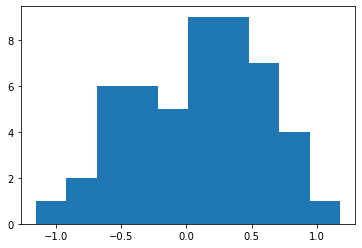

In [198]:
input = expand_input(torch.randn(5, 3, 32, 32), 10).to(0)
plt.hist(model[:](input).cpu().detach().numpy().flatten())
plt.show()

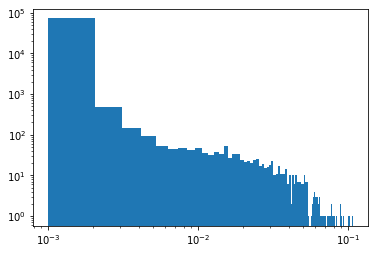

In [28]:
plt.hist(model[5].conv.weight.cpu().detach().numpy().flatten(), bins=100)
plt.xscale("log")
plt.yscale("log")
plt.show()


In [4]:
#update utilty
def set_model_grads(model, output, labels):
    targets = torch.eye(10, device=labels.device)[labels]
    output_error = F.softmax(output, dim=1) - targets
    for i in range(len(model)):
        layer = model[i]
        if type(layer) in (vnn.Conv2d, vnn.Linear):
            if (i == len(model) - 1) or (type(model[i+1]) not in (vnn.ReLU, vnn.tReLU)):
                mask = torch.ones(layer.mask_shape, device=output.device)
            else:
                mask = model[i+1].mask
            layer.set_grad(mask, output_error)
        
#input utility
def expand_input(input, category_dim):
    #input = (batch, channels, width, height)
    batch_size, in_channels = input.shape[:2]
    expanded_input = torch.zeros((batch_size, category_dim, in_channels*category_dim) + input.shape[2:])
    for i in range(category_dim):
        expanded_input[:, i, i*in_channels:(i+1)*in_channels] = input
    return expanded_input
            

In [190]:
#load cifar-10

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [100]:
#loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0)

for epoch_idx in range(1000):
    print("epoch", epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        nans = torch.any(torch.isnan(model[2].conv.weight)).item()
        if nans:
            print("NAN!")
        #print(model[3].conv.weight)
        #print("batch", batch_idx)
        input = expand_input(data, 10).to(0)
        optimizer.zero_grad()
        output = model(input)[..., 0]
        #loss = loss_fn(output.detach(), labels)
        #epoch_loss += loss.item()
        correct = (output.detach().cpu().argmax(dim=1) == labels).float().sum().item()
        #print(correct / 128.)
        epoch_correct += correct
        
        set_model_grads(model, output, labels.to(0))
        #print(model[0].conv.weight.grad)
        torch.nn.utils.clip_grad_norm_(model.parameters(), .1)
        optimizer.step()
        #for layer in model:
        #    layer.post_step_callback()
            

    print(epoch_correct / 50000.)
    #print(epoch_loss / (batch_idx + 1))



epoch 0
Instantiated t with shape (10, 32, 30, 30)
Instantiated t with shape (10, 64, 28, 28)
Instantiated t with shape (10, 128, 12, 12)
Instantiated t with shape (10, 128, 10, 10)
Instantiated t with shape (10, 256, 3, 3)
Instantiated t with shape (10, 256, 1, 1)
Instantiated t with shape (10, 1024)
Instantiated t with shape (10, 512)
0.10054
epoch 1


KeyboardInterrupt: 

In [199]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch_idx in range(1000):
    print(epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        if batch_idx % 100 == 0:
            print(batch_idx)
        input = expand_input(data, 10).to(0)
        out = model(input)[..., 0]
        loss = loss_fn(out, labels.to(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        for layer in model[1:]: layer.post_step_callback()
        epoch_loss += loss.item()
        epoch_correct += (out.detach().cpu().argmax(dim=1) == labels).float().sum().item()
    print("correct", epoch_correct / 50000.)
    print("loss", epoch_loss / (batch_idx + 1))

    

0
0
100
200
300
correct 0.26804
loss 2.059814945206313
1
0
100
200
300
correct 0.32188
loss 1.889460609087249
2
0
100
200
300
correct 0.34726
loss 1.8273332948270051
3
0
100
200
300
correct 0.35988
loss 1.7867720560039706
4
0
100
200
300
correct 0.37438
loss 1.757153989408937
5
0


KeyboardInterrupt: 

In [147]:

epoch_correct = 0.
for batch_idx, (data, labels) in enumerate(test_loader):
    input = expand_input(data, 10).to(0)
    out = model(input)[..., 0]
    epoch_correct += (out.detach().cpu().argmax(dim=1) == labels).float().sum()

print(epoch_correct / 10000.)



tensor(0.4966)


In [99]:
out = model(input)

Instantiated t with shape (10, 32, 30, 30)
Instantiated t with shape (10, 64, 28, 28)
Instantiated t with shape (10, 128, 12, 12)
Instantiated t with shape (10, 128, 10, 10)
Instantiated t with shape (10, 256, 3, 3)
Instantiated t with shape (10, 256, 1, 1)
Instantiated t with shape (10, 1024)
Instantiated t with shape (10, 512)


In [100]:
out

tensor([[[ 5015921.5000],
         [ 3048779.0000],
         [ 2860563.0000],
         ...,
         [  904737.7500],
         [ 3212645.5000],
         [-2308516.7500]],

        [[-2976155.5000],
         [-2003627.6250],
         [-1668159.3750],
         ...,
         [ -301107.5000],
         [-1824721.1250],
         [  458257.1562]],

        [[  -56928.6328],
         [ -421825.1250],
         [ -220883.4688],
         ...,
         [ -646944.3750],
         [-1433247.7500],
         [  810331.3750]],

        ...,

        [[ 6916157.0000],
         [ 1867002.8750],
         [ 2697788.2500],
         ...,
         [  413962.9688],
         [ 2753534.5000],
         [ 1709518.6250]],

        [[ 1949936.5000],
         [ -515905.3438],
         [  137847.6406],
         ...,
         [   55038.9023],
         [ -103463.7188],
         [ 1440541.7500]],

        [[-2459864.0000],
         [  615623.3125],
         [-1055614.1250],
         ...,
         [ -136023.7500],
        